# Email Spam Detection<a class="anchor"  id="3"></a>

<img src="email.jpg" alt="Alt Text" width="600" height="50" align="center">
 

# Task 4 Email Spam Detection
## Project Overview:

#### Build a machine learning model to classify emails as "spam" or "ham." Clean and preprocess the dataset, convert text to numerical features using TF-IDF, and train multiple models. Evaluate models based on metrics like accuracy, precision, and recall. Visualize results using a confusion matrix and classification report. This project showcases automated email classification for improved communication management.

# 1. Loading, data explorating and preprocessing<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [3]:
df = pd.read_csv("spam_ham_dataset.csv")

In [4]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
df.shape

(5171, 4)

In [6]:
df1 = df.drop("Unnamed: 0",axis=1)

In [7]:
df1.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
df1["text"][0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

##### The raw E-Mails have a lot of characters beside of the ones of the alphabet, which might provoke issues later. Therefore, the E-Mails will be cleaned.

In [10]:
from nltk.tokenize import RegexpTokenizer

def clean_text(text, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a text with RegexpTokenizer
    text = text.lower()
    tokens = reg.tokenize(text)
    return " ".join(tokens)

In [11]:
print('Before cleaning:')
df1['text'][0]

Before cleaning:


"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [12]:
print('After cleaning:')
clean_text(df1['text'][0])

After cleaning:


'subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes'

In [13]:
# Create a new column with the cleaned messages
df1['text_cleaned'] = df1['text'].apply(lambda text: clean_text(text))

# Display the result
df1.head()

,label,text,label_num,text_cleaned
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter this is a follow ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom for january see attached file ...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho we re around to ...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject re indian springs this deal is to book...


## Handling Class Imbalance:

In [14]:
df1["label"].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

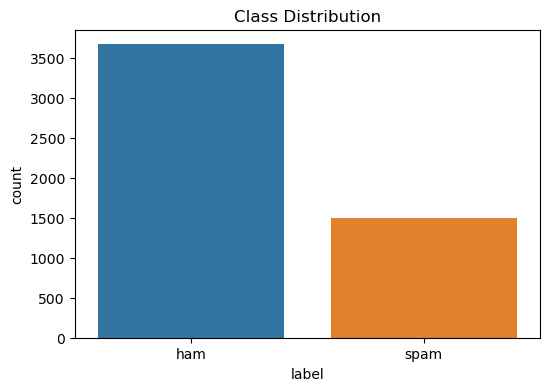

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df1, x='label')
plt.title('Class Distribution')
plt.show()

## Text Vectorization

In [52]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X = tfidf_vectorizer.fit_transform(df1['text_cleaned']).toarray()
y = df1['label_num']

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))


Class distribution before SMOTE: Counter({0: 3672, 1: 1499})
Class distribution after SMOTE: Counter({0: 3672, 1: 3672})


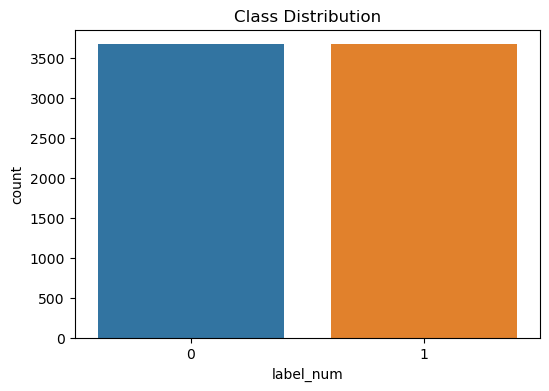

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df1, x=y_resampled)
plt.title('Class Distribution')
plt.show()

## Train Test Split

In [19]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

#  Model comparison<a class="anchor" id="2"></a>


In [20]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 16.28 sec
Gradient Boosting    trained in 312.22 sec
XGBoost              trained in 76.66 sec
MultinomialNB        trained in 0.12 sec
Logistic Regr.       trained in 2.24 sec
KNN                  trained in 0.06 sec
Decision Tree        trained in 47.32 sec
SVM (Linear)         trained in 0.47 sec
SVM (RBF)            trained in 57.19 sec


In [25]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [26]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,SVM (RBF),0.989108,57.19
1,SVM (Linear),0.986385,0.47
2,Logistic Regr.,0.974813,2.24
3,Random Forest,0.972771,16.28
4,XGBoost,0.971409,76.66
5,MultinomialNB,0.965283,0.12
6,Decision Tree,0.965283,47.32
7,Gradient Boosting,0.956433,312.22
8,KNN,0.869299,0.06


## Confusion Matrix of each model

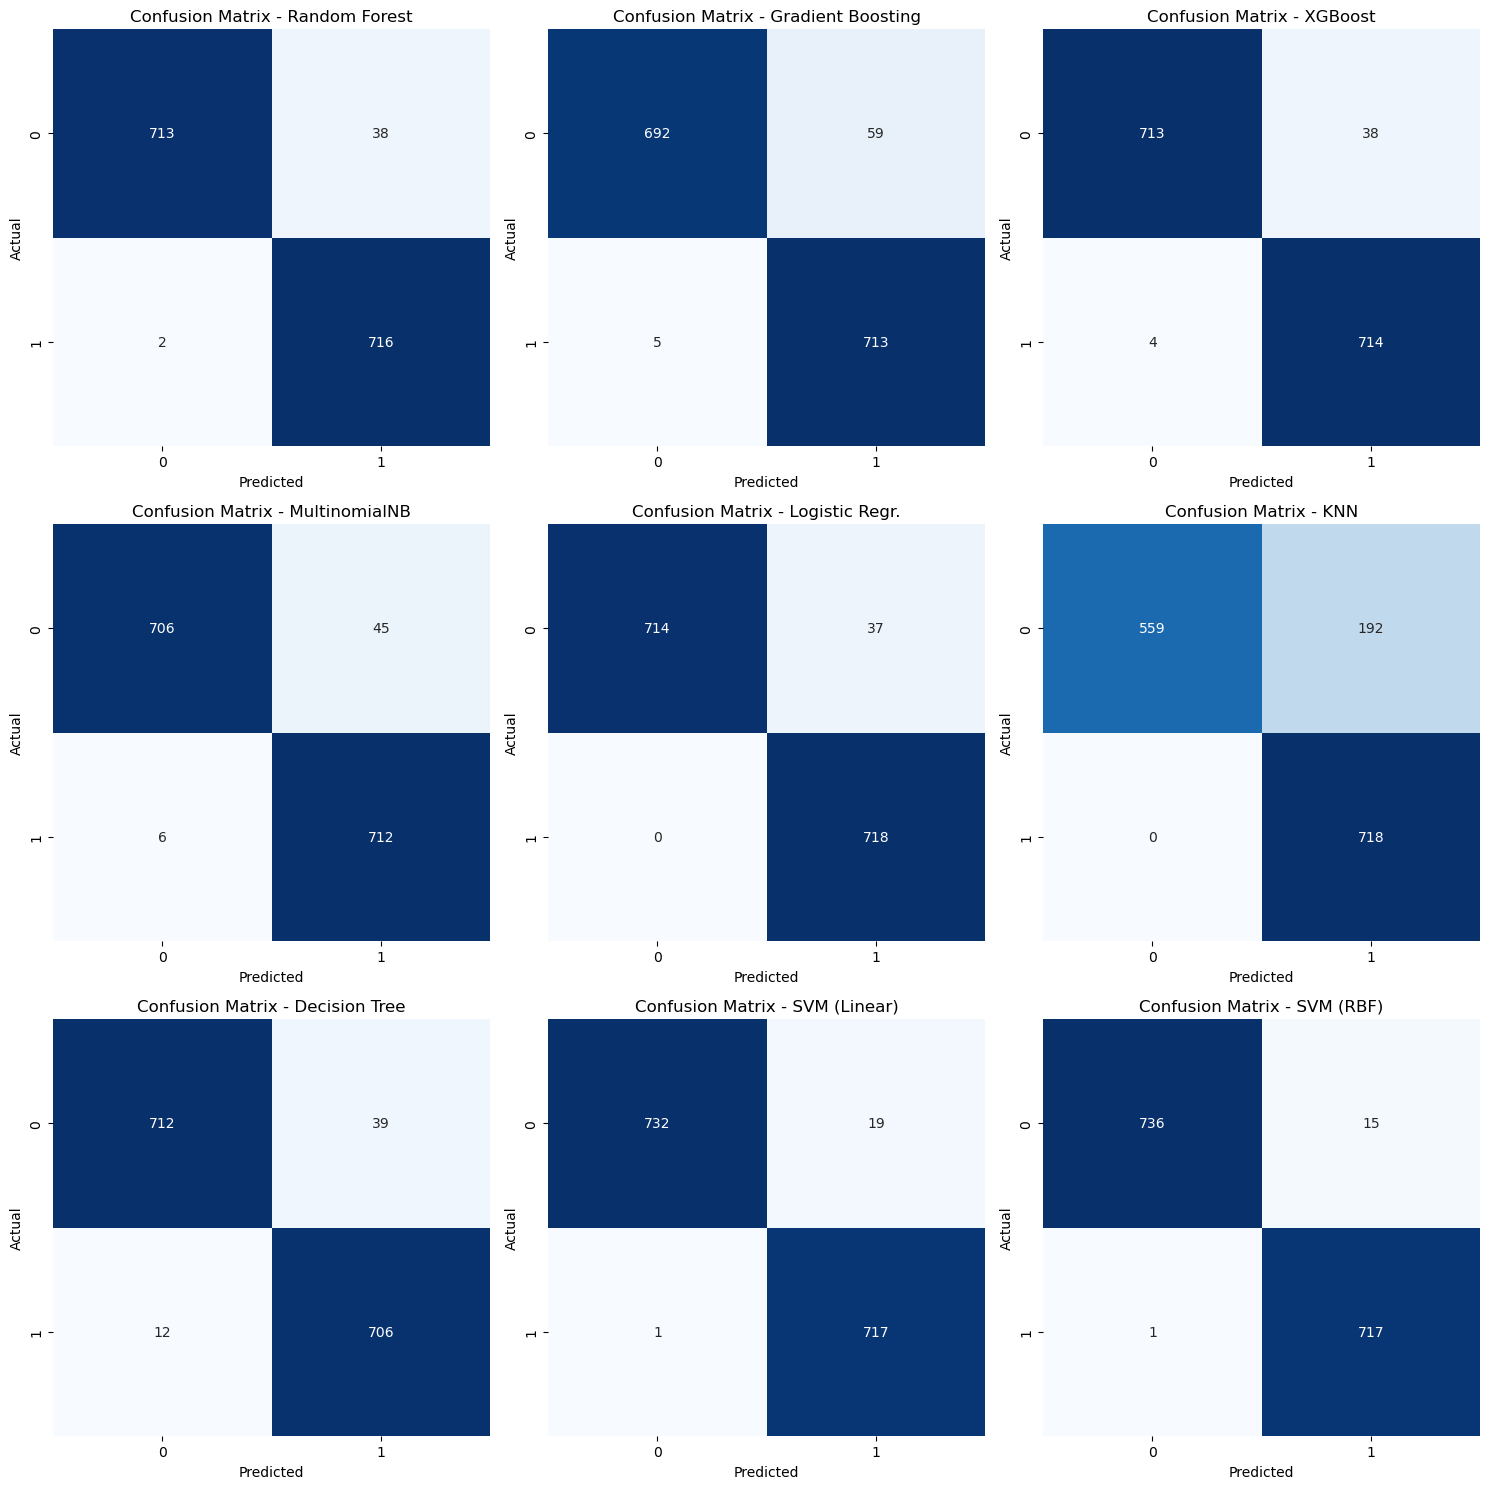

In [31]:
def plot_confusion_matrix(model, name, ax):
    y_pred = model['model'].predict(X_test)  # Replace X_test with your test data
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Assuming you have trained models and got predictions for each model
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

if num_models == 1:
    axes = [axes]

for (name, model), ax in zip(models.items(), axes.flat):
    plot_confusion_matrix(model, name, ax)

plt.tight_layout()
plt.show()

## Classification Model of each Model

In [30]:
from sklearn.metrics import classification_report

# Assuming you have trained models and got predictions for each model
for name, model in models.items():
    y_pred = model['model'].predict(X_test)  # Replace X_test with your test data
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    print("=" * 50)


Model: Random Forest
Confusion Matrix:
[[713  38]
 [  2 716]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       751
           1       0.95      1.00      0.97       718

    accuracy                           0.97      1469
   macro avg       0.97      0.97      0.97      1469
weighted avg       0.97      0.97      0.97      1469

Model: Gradient Boosting
Confusion Matrix:
[[692  59]
 [  5 713]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       751
           1       0.92      0.99      0.96       718

    accuracy                           0.96      1469
   macro avg       0.96      0.96      0.96      1469
weighted avg       0.96      0.96      0.96      1469

Model: XGBoost
Confusion Matrix:
[[713  38]
 [  4 714]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95     

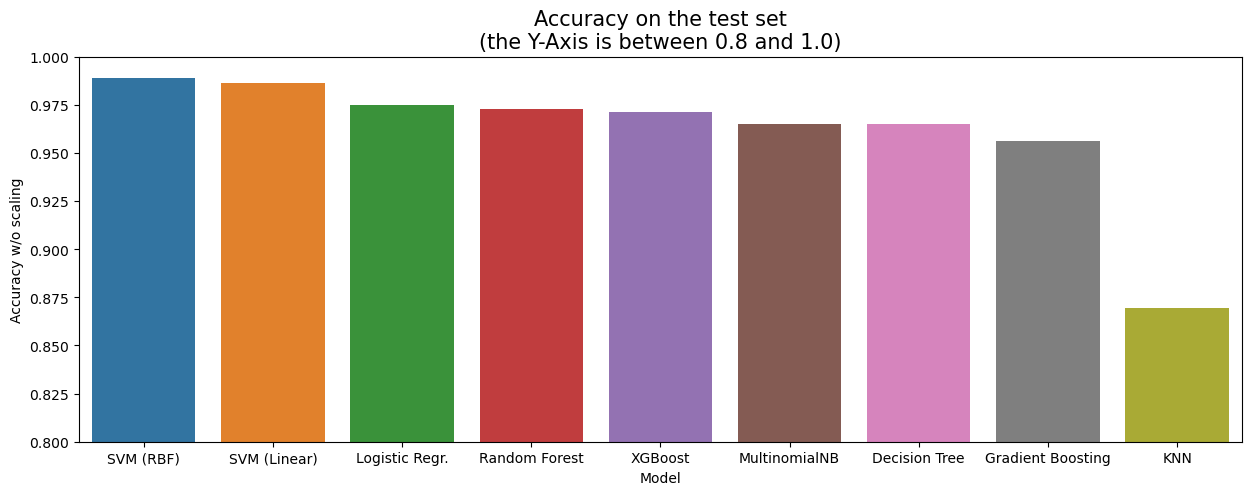

In [23]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

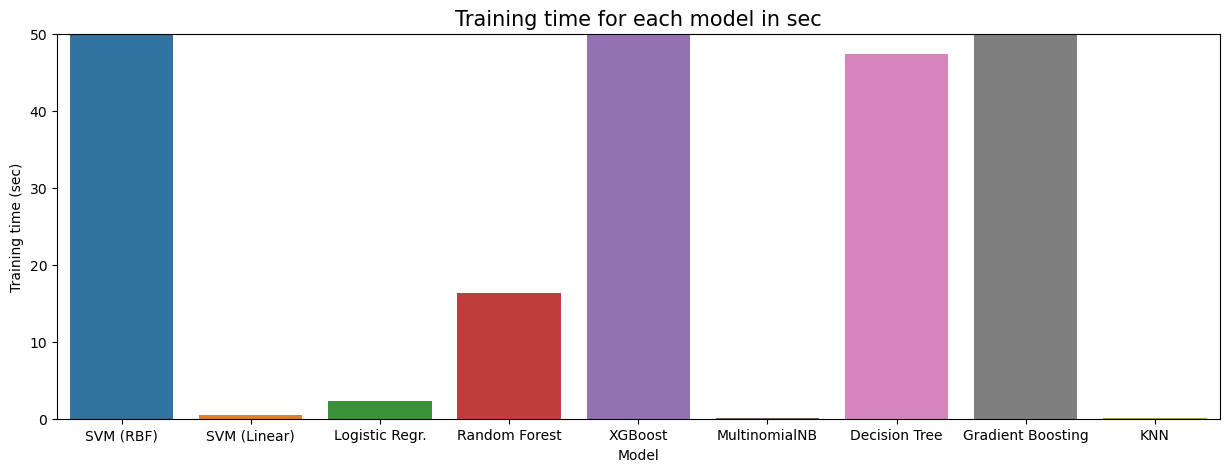

In [68]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_acc)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,50)
plt.show()

XGBoosting gives the best result on the test set. Nevertheless, MultinomialNB is nearly as good, but is very fast . In the following part, we'll choose the MultinomialNB and try various hyperparameters to optimize it.

In [9]:
df1.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


# 3. Hyperparameter selection for MultinomialNB<a class="anchor" id="3"></a>

In [34]:
# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
0,"{'alpha': 0.2, 'fit_prior': True}",0.970383
1,"{'alpha': 0.2, 'fit_prior': False}",0.970383
3,"{'alpha': 1, 'fit_prior': False}",0.966809
2,"{'alpha': 1, 'fit_prior': True}",0.966638
5,"{'alpha': 2, 'fit_prior': False}",0.964766
4,"{'alpha': 2, 'fit_prior': True}",0.964766
7,"{'alpha': 5, 'fit_prior': False}",0.963574
6,"{'alpha': 5, 'fit_prior': True}",0.963234
9,"{'alpha': 10, 'fit_prior': False}",0.962723
8,"{'alpha': 10, 'fit_prior': True}",0.962383


In [35]:
# Display the best hyperparameters
grid.best_params_

{'alpha': 0.2, 'fit_prior': True}

# The MultinomialNB Model<a class="anchor" id="4"></a>

In [37]:
# Create the model with the best hyperparameters
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

## Accuracy: 96.89999999999999%



In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       751
           1       0.95      0.99      0.97       718

    accuracy                           0.97      1469
   macro avg       0.97      0.97      0.97      1469
weighted avg       0.97      0.97      0.97      1469



#  Example of predictions<a class="anchor" id="5"></a>

In [70]:

X_input = tfidf_vectorizer.transform([df1["text_cleaned"][0]]).toarray()
print("Input Email:\n", df1["text_cleaned"][0])
# Predict using the chosen model
prediction = model.predict(X_input)
if prediction[0]==1:
    print("\nPredicted Label:", "SPAM")
else:
    print("\nPredicted Label:", "HAM") 

Input Email:
 subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes

Predicted Label: HAM


# END 